In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from tqdm import tqdm
import scipy.io

%matplotlib inline

import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

### Load the light sources, cameras, and macbeth color chart

In [15]:
#CIE Illuminants A and D65
df_A = pd.read_excel("D65_and_A.xls", skiprows = 5, usecols = [0,1], names = ["wavelength", "illumination"])
df_D65 = pd.read_excel("D65_and_A.xls", skiprows = 5, usecols = [6,7], names = ["wavelength", "illumination"])

#CIE Fluorescent lamps
df_fluorescent = pd.read_excel("Fluorescents.xls", skiprows = 1)
df_fluorescent.rename(columns={'Unnamed: 0':'wavelength'}, inplace=True)

df_fluorescentF1 = df_fluorescent[['wavelength', 'F1']]
df_fluorescentF1.rename(columns = {'F1':'illumination'}, inplace = True)

df_fluorescentF7 = df_fluorescent[['wavelength', 'F7']]
df_fluorescentF7.rename(columns = {'F7':'illumination'}, inplace = True)

df_fluorescentF10 = df_fluorescent[['wavelength', 'F10']]
df_fluorescentF10.rename(columns = {'F10':'illumination'}, inplace = True)

df_macbeth = pd.read_excel("MacbethColorChecker.xls", skiprows = 2, usecols = np.arange(0,25))

#Camera Sensitivity
df_sony = pd.read_excel("Sony_Dxc_930.xlsx").iloc[:, 0].str.split(' ', expand=True)
df_sony.rename(columns={0:'wavelength', 1: 'red', 2: 'green', 3: 'blue'}, inplace=True)
df_sony = df_sony.apply(pd.to_numeric)

df_kodak = pd.read_excel("Kodak_Dcs_420.xlsx").iloc[:, 0].str.split(' ', expand=True)
df_kodak.rename(columns={0:'wavelength', 1: 'red', 2: 'green', 3: 'blue'}, inplace=True)
df_kodak = df_kodak.apply(pd.to_numeric)

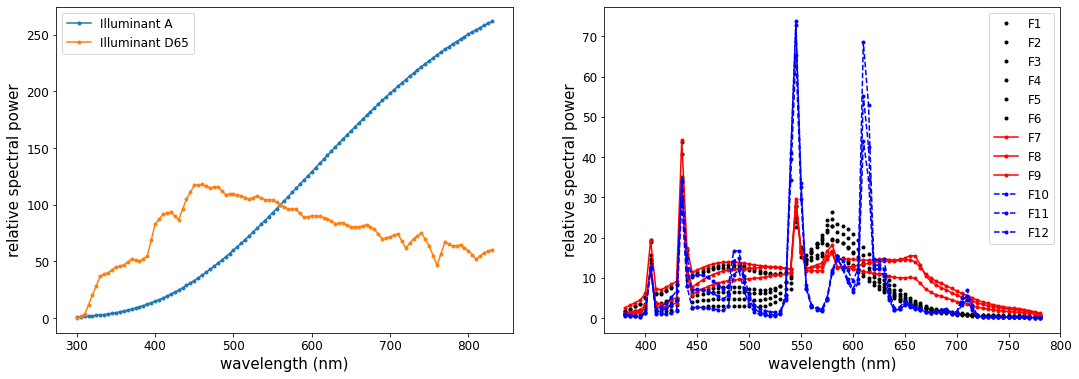

In [3]:
plt.figure(figsize = (18,6))
plt.subplot(121)
plt.plot(df_A.wavelength, df_A.illumination, '.-', label = "Illuminant A")
plt.plot(df_D65.wavelength, df_D65.illumination, '.-', label = "Illuminant D65")
plt.xlabel("wavelength (nm)", fontsize = 15)
plt.ylabel("relative spectral power", fontsize = 15)
plt.legend(fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.subplot(122)
for i in df_fluorescent.columns.values.tolist()[1:]:
    if i in ["F1", "F2", "F3", "F4", "F5", "F6"]: #Common Illuminants
        plt.plot(df_fluorescent.wavelength, df_fluorescent[i], '.', color = "black",  label = i)
    if i in ["F7", "F8", "F9"]: # High Color Rendering Illuminants
        plt.plot(df_fluorescent.wavelength, df_fluorescent[i], '.-', color = "red",  label = i)
    if i in ["F10", "F11", "F12"]: #Three Band Illuminants
        plt.plot(df_fluorescent.wavelength, df_fluorescent[i], '.--', color = "blue",  label = i)

plt.xlabel("wavelength (nm)", fontsize = 15)
plt.ylabel("relative spectral power", fontsize = 15)
plt.legend(fontsize = 12)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.savefig("Figures/light_sources.png", dpi = 300, bbox_inches = "tight")
plt.show()

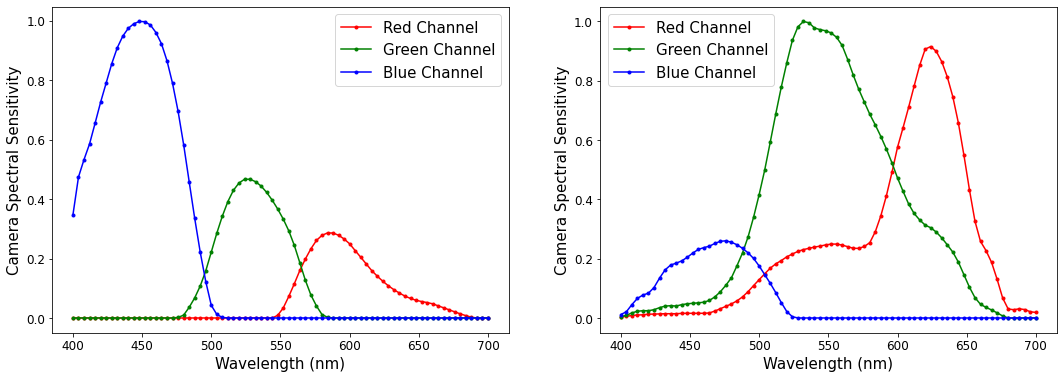

In [4]:
plt.figure(figsize = (18,6))
plt.subplot(121)
plt.plot(df_sony.wavelength, df_sony.red, '.-', color = 'red', label = 'Red Channel')
plt.plot(df_sony.wavelength, df_sony.green, '.-', color = 'green', label = 'Green Channel')
plt.plot(df_sony.wavelength, df_sony.blue, '.-', color = 'blue', label = 'Blue Channel')
#plt.plot(df_D65.wavelength, df_D65.illumination/df_D65.illumination.max(), '.-', label = "Kodak DCS-420")
plt.xlabel("Wavelength (nm)", fontsize = 15)
plt.ylabel("Camera Spectral Sensitivity", fontsize = 15)
plt.legend(fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.subplot(122)
plt.plot(df_kodak.wavelength, df_kodak.red, '.-', color = 'red', label = 'Red Channel')
plt.plot(df_kodak.wavelength, df_kodak.green, '.-', color = 'green', label = 'Green Channel')
plt.plot(df_kodak.wavelength, df_kodak.blue, '.-', color = 'blue', label = 'Blue Channel')
#plt.plot(df_D65.wavelength, df_D65.illumination/df_D65.illumination.max(), '.-', label = "Kodak DCS-420")
plt.xlabel("Wavelength (nm)", fontsize = 15)
plt.ylabel("Camera Spectral Sensitivity", fontsize = 15)
plt.legend(fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.savefig("Figures/cameraa.png", bbox_inches = "tight", dpi = 300)
plt.show()

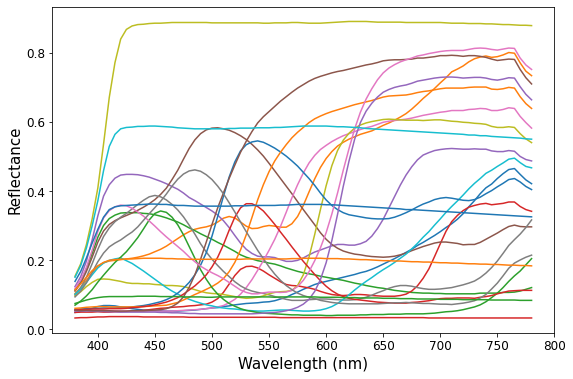

In [9]:
plt.figure(figsize = (9,6))
for i in df_macbeth.columns[1:]:
    plt.plot(df_macbeth.wavelength, df_macbeth[i])
plt.xlabel("Wavelength (nm)", fontsize = 15)
plt.ylabel("Reflectance", fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.savefig('Figures/macbeth_reflectance.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [11]:
def color_output(wavelength, P, R, Sr, Sg, Sb): 
    """
    Input:
    P - light source spectral power distribution
    R - reflectance of the object
    S - camera spectral sensitivity (red, green, and blue channels)
    
    Output:
    C - camera output [R,G,B]
    """
    
    Cr = sum(P * R * Sr) / sum(P * Sr)
    Cg = sum(P * R * Sg) / sum(P * Sg)
    Cb = sum(P * R * Sb) / sum(P * Sb)
    
    C = [Cr, Cg, Cb]
    
    return C

def visualize_color(intensity, color):
    output = np.zeros([10,10,3])
    output[:,:,0] = int(color[0]*intensity)
    output[:,:,1] = int(color[1]*intensity)
    output[:,:,2] = int(color[2]*intensity)
    output = output.astype(int)
    
    plt.imshow(output)
    plt.axis('off')
    plt.title('RGB: (' + str(int(color[0]*intensity)) + ',' + str(int(color[1]*intensity)) + ',' + str(int(color[2]*intensity)) + ')', fontsize=15)
    plt.show()

In [35]:
def recreate_image(df_camera, df_object, df_light_source, intensity, camera_name, light_name):
    '''
    df_camera should have columns with names 'wavelength', 'red', 'green', and 'blue'
    df_object should have columns with names 'wavelength', and reflectance values
    df_light_source should have columns with 'wavelength' and 'illumination'
    title is the name of the object
    '''
    N = 24 #number of macbeth colors
    macbeth = np.zeros([N,N,3])
    colors = []
    
    for i in [i for i in df_object.columns][1:]:
        wavelength = np.copy(df_object.wavelength)
        light_source = np.interp(wavelength, df_light_source.wavelength, df_light_source.illumination)
        camera_red = np.interp(wavelength, df_camera.wavelength, df_camera.red)
        camera_green = np.interp(wavelength, df_camera.wavelength, df_camera.green)
        camera_blue = np.interp(wavelength, df_camera.wavelength, df_camera.blue)

        color = color_output(wavelength, light_source, df_object[i], camera_red, camera_green, camera_blue)
        colors.append(color)
    
    colors = np.array(colors)
    colors_df = pd.DataFrame(colors, columns = ['red', 'green', 'blue'])
    colors_df_tosave = colors_df.copy()
    colors_df_tosave['red'] *= intensity
    colors_df_tosave['green'] *= intensity
    colors_df_tosave['blue'] *= intensity
    #colors_df_tosave['red'] = colors_df_tosave['red'] * sum(light_source * camera_red)
    #colors_df_tosave['green'] = colors_df_tosave['green'] * sum(light_source * camera_green)
    #colors_df_tosave['blue'] = colors_df_tosave['blue'] * sum(light_source * camera_blue)
    colors_df_tosave.to_csv('RGB_Vals/macbeth_'+str(camera_name)+'_'+str(light_name)+'_'+'.csv', index = 'false')
    
    macbeth[:,:,0] = colors[:,0] * intensity
    macbeth[:,:,1] = colors[:,1] * intensity
    macbeth[:,:,2] = colors[:,2] * intensity

    macbeth = macbeth.astype(int)

    array1 = np.array([macbeth[0][0:6]])
    array2 = np.array([macbeth[0][6:12]])
    array3 = np.array([macbeth[0][12:18]])
    array4 = np.array([macbeth[0][18:24]])

    array_camera = np.vstack((array1,array2, array3, array4))
    #print(array_camera.max())
    array_camera[array_camera > 255] = 255
        
    return array_camera

In [36]:
def recreate_macbeth(array):
    #plt.figure(figsize=[9,6])
    plt.imshow(array)
    for i in range(5):
        plt.axhline(y=-0.5+i, color='black', linewidth = 5)
    for j in range(7):
        plt.axvline(x=-0.5+j, color='black', linewidth = 5)

    plt.axhline(y=-0.5, color='black', linewidth = 10)
    plt.axhline(y=3.5, color='black', linewidth = 10)
    plt.axvline(x=-0.5, color='black', linewidth = 10)
    plt.axvline(x=5.5, color='black', linewidth = 10)
    plt.axis('off')

In [37]:
light_source_names  = ['A', 'D65', 'F1', 'F7', 'F10']
camera_names = ['SonyDXC-930', 'KodakDCS-420']
camera_used = [df_sony, df_kodak]
light_used = [df_A, df_D65, df_fluorescentF1,  df_fluorescentF1,  df_fluorescentF7]

camera_light_names = [(r[0], r[1]) for r in itertools.product(camera_names, light_source_names)]

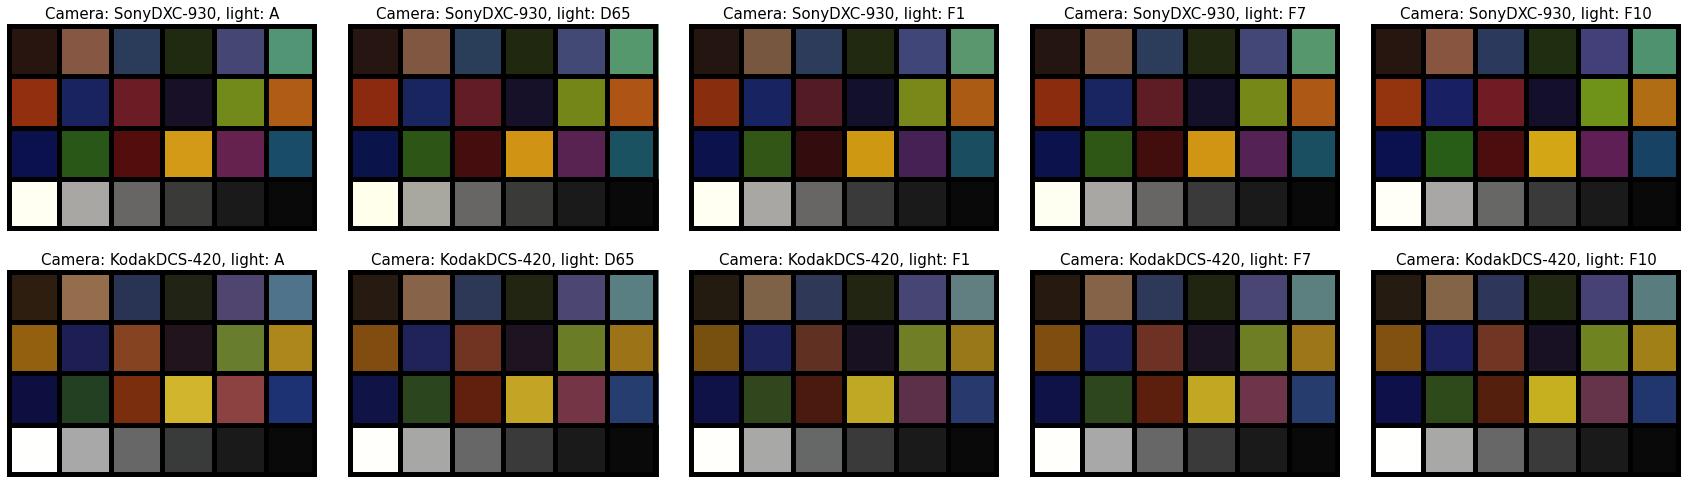

In [38]:
intensity = 255 + 33

plt.figure(figsize = (6*5,6*1.5))
for i, names in enumerate(camera_light_names):
    if names[0] == 'SonyDXC-930': df_camera = df_sony.copy()
    if names[0] == 'KodakDCS-420': df_camera = df_kodak.copy()
    if names[1] == 'A': df_light_source = df_A.copy()
    if names[1] == 'D65': df_light_source = df_D65.copy()
    if names[1] == 'F1': df_light_source = df_fluorescentF1.copy()
    if names[1] == 'F7': df_light_source = df_fluorescentF7.copy()
    if names[1] == 'F10': df_light_source = df_fluorescentF10.copy()
    
    array_macbeth = recreate_image(df_camera, df_macbeth, df_light_source, intensity, names[0], names[1])
    plt.subplot(2,5,i+1)
    recreate_macbeth(array_macbeth)
    plt.title("Camera: "+str(names[0])+ ", light: "+str(names[1]), fontsize = 15)

plt.subplots_adjust(wspace=0.1, hspace=0.01)
plt.savefig('Figures/rendered_macbeth_with_white_balance.png', bbox_inches = 'tight', dpi = 300)
plt.show()

In [98]:
#Measuring Color Difference usign two different cameras

df_2 = pd.read_csv('RGB_Vals/macbeth_KodakDCS-420_A_.csv', usecols = ['red','green', 'blue'])
df_1 = pd.read_csv('RGB_Vals/macbeth_SonyDXC-930_A_.csv', usecols = ['red','green', 'blue'])
df_1 = df_1.astype({'red':'int', 'green':'int', 'blue':'int'})
df_2 = df_2.astype({'red':'int', 'green':'int', 'blue':'int'})

In [99]:
def distance(df_A, df_B):
    d = np.sqrt((df_A.red - df_B.red)**2 + (df_A.green - df_B.green)**2 + (df_A.blue - df_B.blue)**2)
    return d/np.sqrt((255)**2+(255)**2+(255)**2) * 100

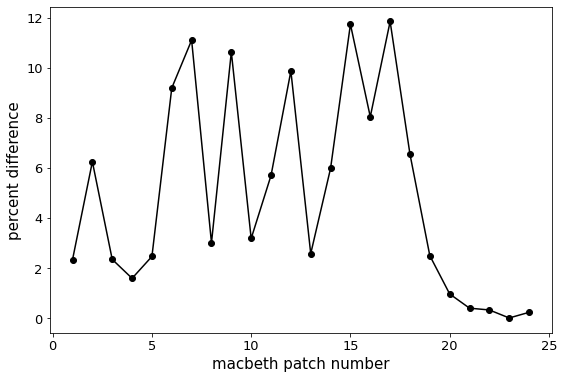

In [112]:
d = distance(df_1, df_2)
plt.figure(figsize = (9,6))
plt.plot(df_macbeth.columns[1:], d, 'ko-')
plt.xlabel('macbeth patch number', fontsize = 15)
plt.ylabel('percent difference', fontsize = 15)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.savefig('Figures/euclidian_distance.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [104]:
def visualize(intensity, color):
    output = np.zeros([10,10,3])
    output[:,:,0] = int(color[0])
    output[:,:,1] = int(color[1])
    output[:,:,2] = int(color[2])
    output = output.astype(int)
    
    plt.imshow(output)
    plt.axis('off')
    plt.title('RGB: (' + str(int(color[0])) + ',' + str(int(color[1])) + ',' + str(int(color[2])) + ')', fontsize=15)

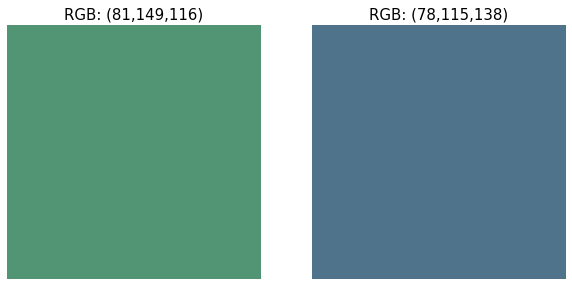

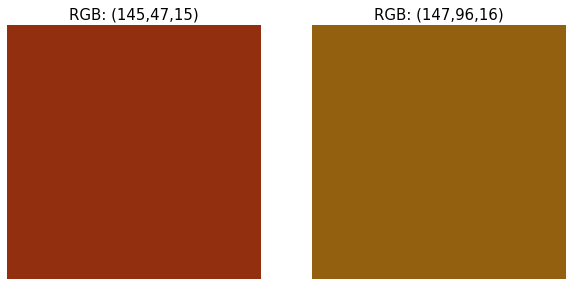

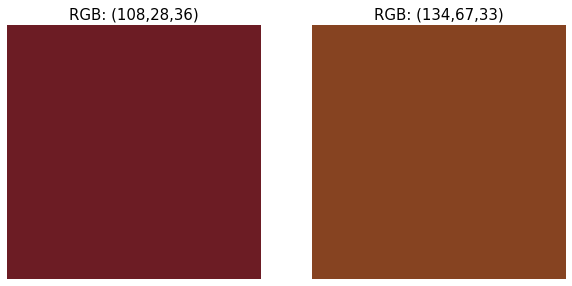

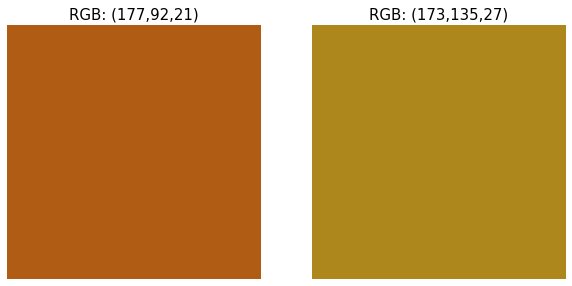

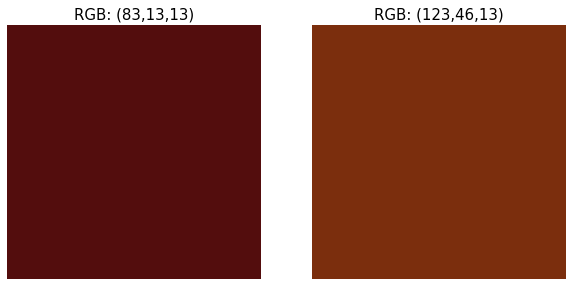

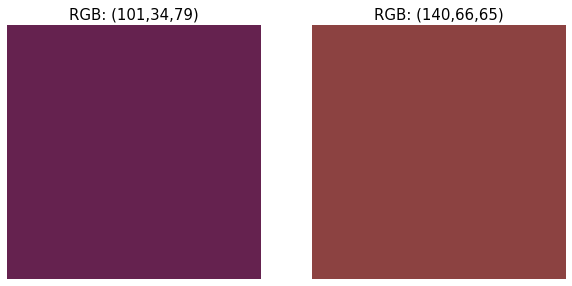

In [111]:
patches = [6,7,9,12,15,17]
for i in patches:
    plt.figure(figsize = (10,5))
    plt.subplot(121)
    visualize(1, [df_1.red[i-1], df_1.green[i-1],df_1.blue[i-1]])
    plt.subplot(122)
    visualize(1, [df_2.red[i-1], df_2.green[i-1],df_2.blue[i-1]])
    plt.savefig('Figures/patch_number_'+str(i)+'.png', bbox_inches = 'tight', dpi = 300)
    plt.show()

In [114]:
#Measuring Color Difference usign two different light sources

df_2 = pd.read_csv('RGB_Vals/macbeth_SonyDXC-930_D65_.csv', usecols = ['red','green', 'blue'])
df_1 = pd.read_csv('RGB_Vals/macbeth_SonyDXC-930_A_.csv', usecols = ['red','green', 'blue'])
df_1 = df_1.astype({'red':'int', 'green':'int', 'blue':'int'})
df_2 = df_2.astype({'red':'int', 'green':'int', 'blue':'int'})

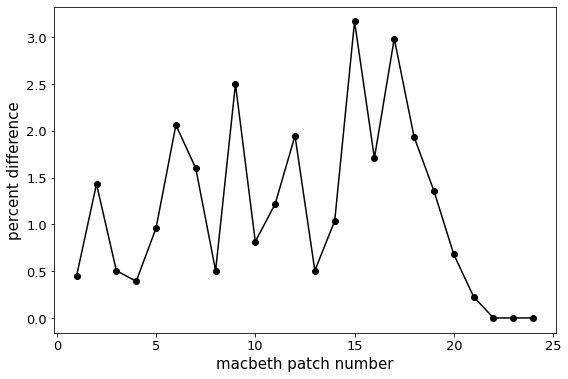

In [115]:
d = distance(df_1, df_2)
plt.figure(figsize = (9,6))
plt.plot(df_macbeth.columns[1:], d, 'ko-')
plt.xlabel('macbeth patch number', fontsize = 15)
plt.ylabel('percent difference', fontsize = 15)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.savefig('Figures/euclidian_distance_2.png', dpi = 300, bbox_inches = 'tight')
plt.show()

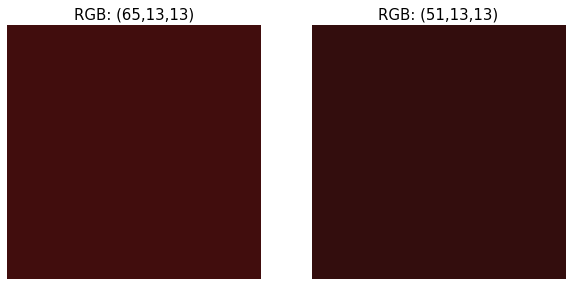

In [119]:
patches = [15]
for i in patches:
    plt.figure(figsize = (10,5))
    plt.subplot(121)
    visualize(1, [df_1.red[i-1], df_1.green[i-1],df_1.blue[i-1]])
    plt.subplot(122)
    visualize(1, [df_2.red[i-1], df_2.green[i-1],df_2.blue[i-1]])
    plt.savefig('Figures/patch_number_'+str(i)+'_2.png', bbox_inches = 'tight', dpi = 300)
    plt.show()

In [116]:
df_2 = pd.read_csv('RGB_Vals/macbeth_SonyDXC-930_F1_.csv', usecols = ['red','green', 'blue'])
df_1 = pd.read_csv('RGB_Vals/macbeth_SonyDXC-930_F7_.csv', usecols = ['red','green', 'blue'])
df_1 = df_1.astype({'red':'int', 'green':'int', 'blue':'int'})
df_2 = df_2.astype({'red':'int', 'green':'int', 'blue':'int'})

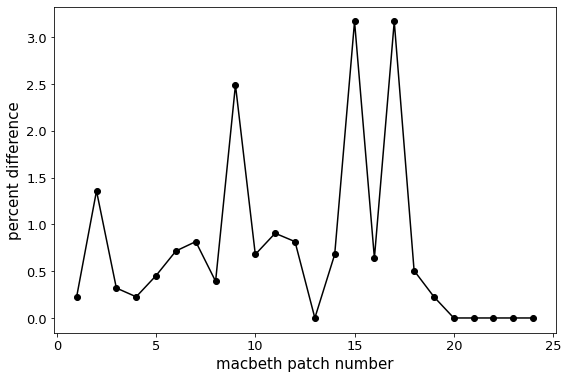

In [117]:
d = distance(df_1, df_2)
plt.figure(figsize = (9,6))
plt.plot(df_macbeth.columns[1:], d, 'ko-')
plt.xlabel('macbeth patch number', fontsize = 15)
plt.ylabel('percent difference', fontsize = 15)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.savefig('Figures/euclidian_distance_3.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [120]:
list(zip(df_macbeth.columns[1:], d))

[(1, 0.2264118702704415),
 (2, 1.3584712216226489),
 (3, 0.3201947376187161),
 (4, 0.2264118702704415),
 (5, 0.452823740540883),
 (6, 0.7159771993531583),
 (7, 0.8163396076337774),
 (8, 0.39215686274509803),
 (9, 2.490530572974856),
 (10, 0.6792356108113244),
 (11, 0.905647481081766),
 (12, 0.8163396076337774),
 (13, 0.0),
 (14, 0.6792356108113244),
 (15, 3.16976618378618),
 (16, 0.6403894752374322),
 (17, 3.16976618378618),
 (18, 0.5062723328375709),
 (19, 0.2264118702704415),
 (20, 0.0),
 (21, 0.0),
 (22, 0.0),
 (23, 0.0),
 (24, 0.0)]

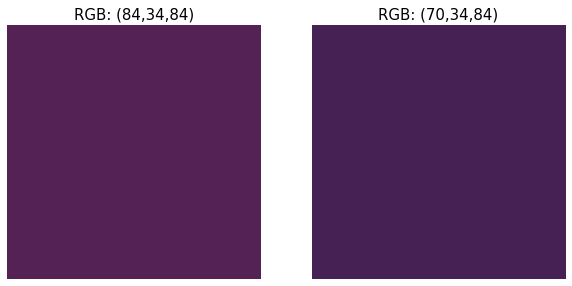

In [121]:
patches = [17]
for i in patches:
    plt.figure(figsize = (10,5))
    plt.subplot(121)
    visualize(1, [df_1.red[i-1], df_1.green[i-1],df_1.blue[i-1]])
    plt.subplot(122)
    visualize(1, [df_2.red[i-1], df_2.green[i-1],df_2.blue[i-1]])
    plt.savefig('Figures/patch_number_'+str(i)+'_3.png', bbox_inches = 'tight', dpi = 300)
    plt.show()